# Importing Modules

In [1]:
import tensorflow as tf
import torch
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15,10)
plt.rcParams['font.size'] = 13

%load_ext tensorboard

# rm -rf ./logs/

In [2]:
reviews = pd.read_csv('oneplus_labeled_data_oversampled.csv')

In [3]:
# Checking for GPU support
tf.test.is_built_with_cuda(), tf.config.list_physical_devices('GPU')

(True, [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

# EDA

In [4]:
reviews.tail()

,lemmatized,Sentiment
5608,camera bad,Negative
5609,camera stop work month fast charging isn t wor...,Negative
5610,set clone app whatsapp doneclone whatsapp pr k...,Negative
5611,phone lag 22 storage,Negative
5612,bhai koi bhi plus nord 2 ko mt lena bahut jyad...,Negative


In [5]:
reviews.describe()

,lemmatized,Sentiment
count,5602,5613
unique,4687,3
top,good product,Positive
freq,12,2024


In [6]:
reviews.isnull().sum()

lemmatized    11
Sentiment      0
dtype: int64

In [7]:
reviews.dropna(inplace= True)
reviews.reset_index(inplace = True)
reviews.drop('index', axis = 1, inplace = True)

In [8]:
reviews.isnull().sum()

lemmatized    0
Sentiment     0
dtype: int64

In [9]:
reviews.tail()

,lemmatized,Sentiment
5597,camera bad,Negative
5598,camera stop work month fast charging isn t wor...,Negative
5599,set clone app whatsapp doneclone whatsapp pr k...,Negative
5600,phone lag 22 storage,Negative
5601,bhai koi bhi plus nord 2 ko mt lena bahut jyad...,Negative


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

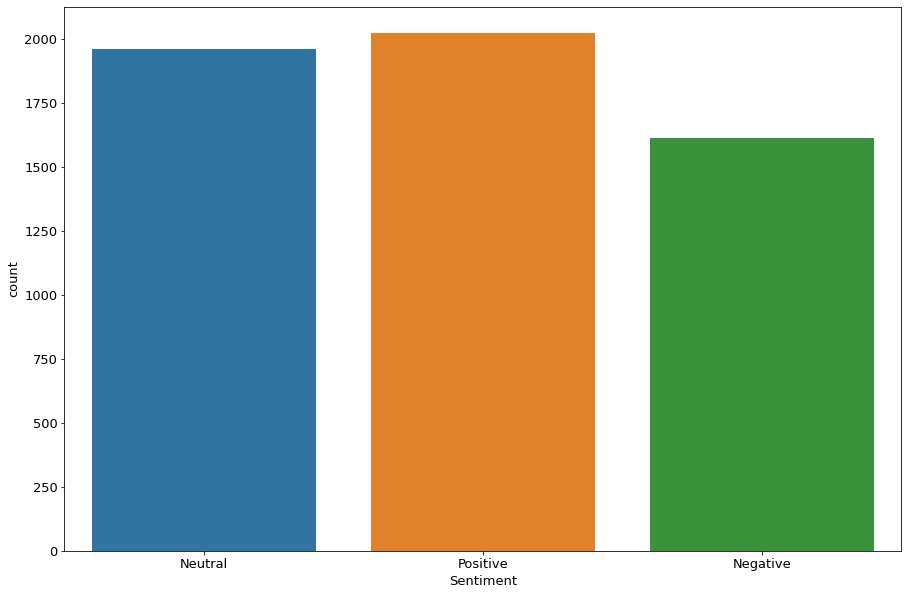

In [10]:
sns.countplot(x = reviews['Sentiment'])

In [11]:
reviews.duplicated().sum()

915

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

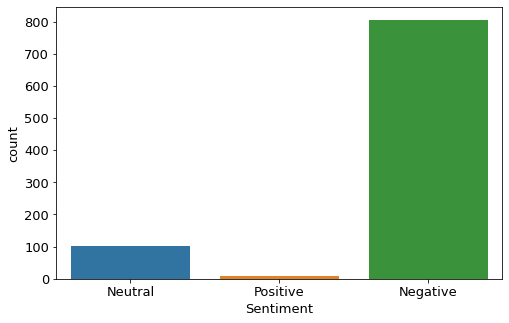

In [12]:
plt.figure(figsize= (8,5))
sns.countplot(x= reviews['Sentiment'][reviews.duplicated()])

In [13]:
reviews_1 = reviews.copy()

## Label encoding

In [14]:
def encoding_labels(dataframe, column_name):
    unique_labels = list(dataframe[column_name].unique())
    unique_labels.sort()
    encode_dict = dict(zip(unique_labels, range(len(unique_labels))))
    dataframe[column_name] = dataframe[column_name].map(encode_dict)
    return encode_dict

In [15]:
label_encode_dict = encoding_labels(reviews_1, 'Sentiment')
label_encode_dict

{'Negative': 0, 'Neutral': 1, 'Positive': 2}

In [16]:
reviews_1

,lemmatized,Sentiment
0,review give 24 hrs l find amazing 10 day usage...,1
1,like tell win t give technical review like ytu...,2
2,receive unit 4 hr ago think 1 feel sturdy prem...,2
3,get oneplus nord 2 5 g phone deliver yesterday...,1
4,7 28 receive yesterday impression look feel gr...,0
...,...,...
5597,camera bad,0
5598,camera stop work month fast charging isn t wor...,0
5599,set clone app whatsapp doneclone whatsapp pr k...,0
5600,phone lag 22 storage,0


# Train-test_split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(reviews_1['lemmatized'], reviews_1['Sentiment'], test_size= 0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= 0.25)

In [18]:
x_train.shape, x_val.shape, x_test.shape

((3360,), (1121,), (1121,))

In [19]:
y = reviews_1['Sentiment']

In [20]:
y

0       1
1       2
2       2
3       1
4       0
       ..
5597    0
5598    0
5599    0
5600    0
5601    0
Name: Sentiment, Length: 5602, dtype: int64

# User defined Function

In [21]:
def confusion_metrix_plot(x,y, model):
    ticks = ['Negative', 'Neutral', 'Positive']
    y_predict = np.argmax(model.predict(x), axis = 1)
    conf_table = confusion_matrix(y, y_predict)
    plt.figure(figsize = (8,5))
    sns.heatmap(conf_table, annot= True, fmt= 'd',cmap= sns.dark_palette('purple'),
        xticklabels= ticks, yticklabels= ticks, )
    plt.xlabel('Prediction', fontsize= 16)
    plt.ylabel('Correct Values', fontsize= 16)
    print('\n', classification_report(y, y_predict))

# Tensorflow Models

## Import

In [22]:
from keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, SimpleRNN, RNN
from tensorflow.keras.layers import Dropout, Normalization
# from keras.layers import Flatten
# from keras.layers.recurrent import SimpleRNN

from tensorflow.keras.layers import Embedding, GRU, LSTM, Bidirectional
# from keras.layers import LSTM

from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import datetime
from keras.models import load_model

In [23]:
PATH = 'Model_files/'

## Base Model

As usual first we convert texts in numbers, but in neural network we do this two times.
1. for just representation (Tokenizer)
2. The word embedding which will be trained along model.

Remember that there is no logic or relations in tokenizer, they are just a numbers like label encoding

### Tokenizer

In [24]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words= 7500)
tokenizer.fit_on_texts(reviews_1['lemmatized'])
encoded_reviews = tokenizer.texts_to_sequences(reviews_1['lemmatized'])

In [25]:
tokenizer.word_index['good']

2

In [26]:
textvectorizer = TextVectorization(max_tokens= 7500, output_sequence_length= 150)
textvectorizer.adapt(x_train)

In [27]:
textvectorizer

In [28]:
textvectorizer.get_vocabulary()

['',
 '[UNK]',
 'phone',
 'good',
 'camera',
 'battery',
 '2',
 't',
 'quality',
 'charge',
 's',
 'oneplus',
 'issue',
 'buy',
 '5',
 'fast',
 'day',
 'mobile',
 'bad',
 'nord',
 'plus',
 'like',
 '1',
 '3',
 'performance',
 'time',
 'use',
 'work',
 'app',
 'life',
 'product',
 '4',
 'problem',
 'don',
 'heating',
 'well',
 'drain',
 'feel',
 'price',
 'k',
 'display',
 '30',
 'get',
 'heat',
 'great',
 'overall',
 'experience',
 'screen',
 'device',
 'money',
 'look',
 'os',
 'update',
 'awesome',
 '10',
 'usage',
 'video',
 'amazon',
 'feature',
 'month',
 'review',
 '6',
 'min',
 'm',
 'need',
 'nice',
 'user',
 'purchase',
 'thing',
 'smooth',
 'hang',
 'face',
 'backup',
 'give',
 'poor',
 'range',
 'software',
 'service',
 'lot',
 'expect',
 'speed',
 'come',
 'normal',
 'return',
 'fingerprint',
 'hour',
 '8',
 'average',
 'charger',
 'premium',
 '7',
 'worth',
 'mode',
 'pro',
 'want',
 'game',
 'u',
 'amazing',
 'not',
 '20',
 'think',
 'take',
 'speaker',
 'gb',
 'excellent

As we can see the Model transform texts into numerical data.

### Experiment with tokenizer

In [29]:
print(encoded_reviews[1])
print(reviews_1['lemmatized'][1])

[20, 366, 273, 6, 78, 742, 62, 20, 3651, 54, 719, 654, 632, 62, 845, 1, 68, 20, 1, 36, 93, 39, 91, 917, 84, 16, 879, 16, 257, 154, 19, 5, 152, 36, 446, 273, 6, 238, 39, 16, 1, 257, 918, 1045, 91, 42, 39, 21, 19, 5, 1551, 31, 6, 59, 18, 136, 135, 72, 1, 18, 568, 1714, 633, 100, 1335, 503, 366, 100, 81, 161, 1, 918, 22, 30, 15, 3652, 58, 81, 21, 447, 101, 56, 36, 72, 42, 39, 172, 846, 56, 3653, 72, 18, 296, 5, 34, 40, 22, 46, 198, 145, 318, 37, 13, 189, 108, 30, 35, 11, 1, 87, 214, 12, 78, 279, 1, 172, 2, 318, 2783, 3, 2784, 318, 513, 1, 847, 672, 1552, 3654, 46, 514, 279, 9, 476, 3655, 318, 37, 1160, 59, 1927, 25, 686, 279, 16, 1, 1928, 514, 959, 46, 421, 31, 6, 91, 100, 59, 1336, 959, 100, 592, 477, 1, 2244, 9, 428, 63, 719, 654, 514, 959, 170, 60, 261, 369, 113, 170, 37, 339, 618, 848, 105, 366, 100, 56, 1, 100, 354, 3656, 522, 366, 282, 698, 19, 5, 619, 16, 1, 21, 8, 24, 20, 3657, 1, 880, 189, 1553, 42, 61, 202, 102, 267, 673, 61, 276, 118, 1098, 12, 215, 87, 236, 1, 5, 433, 96, 99, 

In [30]:
all_word = []
for sentence in encoded_reviews:
    for word in sentence:
        all_word.append(word)
all_word = np.array(all_word)
np.unique(all_word)

array([   1,    2,    3, ..., 7255, 7256, 7257])

In [31]:
# it will store the lens of sequences
len_review = []
for sentence in encoded_reviews:
    len_review.append(len(sentence))
len_review = np.array(len_review)


In [32]:
len_review.mean()

22.859157443770084

In [33]:
len_review.max()

392

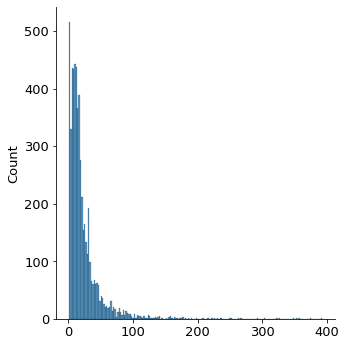

In [34]:

sns.displot(len_review)

In [35]:
tokenizer_dict = dict(tokenizer.word_counts)
tokenizer_values =np.array(list(tokenizer_dict.values()))
tokenizer_dict['zphone']

3

In [36]:
tokenizer_dict['l']

10

In [37]:
tokenizer_values.size, np.unique(tokenizer_values).size

(7257, 270)

In [38]:
len(tokenizer.word_index.keys())

7257

In [39]:
a=tokenizer.get_config()['word_counts']
import json
dict_count = json.loads(a)

In [40]:
dict_count['1']

867

In [41]:
x=list(dict_count.values())
x.sort()

In [42]:
x[7256], dict_count['phone']

(4828, 4828)

- So as we can see the numerical labels are assigned not at random, but in count order.
- The largest the count smallest the label. as we seen in eda file the phone, good have highest count, so these are labeled as 1 and 2 repectively. 
- There are total unique 7258 words, so the labels are extended upto 7257. Tokenizer have diff methods that gives word counts and 

### Padding sequences

So we know that the maxlength of reviews in our data is 392, but mean is 23 and also from distribution plot, we can see that there are very less reviews having len greater that 150,  so we're going to set maxlen = 200. 

Because it we set this parameter larger, the resultant metrix will be spare that is there will be so much 0's

In [43]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


padded_sequence = pad_sequences(encoded_reviews, maxlen = 200, padding= 'post')

In [44]:
padded_sequence[0]

array([  62,   78,  496,  165, 1159,  137,   86,   51,   15,   58, 1159,
        111, 1159,  256,   95,  767, 2242,   22,  603, 1250, 1159,  263,
        497,   18,  199,  365, 1159,  264, 1334,   14,  111,  175,   18,
         65, 2243,   14,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [45]:
padded_sequence.shape

(5602, 200)

### Model

In [46]:
EMBEDDING = 10
INPUT_LENGTH = 200
RNN_LAYERS_1 = 50
VOCAB_SIZE = 7258

Here:
1. input_dim: is the size of vocabolary that is no of words
2. Output_dim = 
3. input_length is the length of sentences, which is 200 in our case
4. mask_zero is True because we are doing padding

In [47]:
RNN_model = Sequential()
RNN_model.add(Embedding(input_dim= VOCAB_SIZE, output_dim= EMBEDDING,input_length= INPUT_LENGTH, mask_zero= True))
RNN_model.add(SimpleRNN(units= RNN_LAYERS_1))
RNN_model.add(Dense(3, activation = 'softmax'))
RNN_model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics= ['accuracy'])
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
# RNN_model.fit() 

In [48]:
RNN_model.fit(padded_sequence, y, epochs= 1, callbacks= tensorboard_callback)

176/176 [==============================] - 228s 1s/step - loss: 0.9645 - accuracy: 0.5469


if we run for 5 epochs the accuracy is 95.43% but it will take 20 min to run

In [49]:
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 10)           72580     
                                                                 
 simple_rnn (SimpleRNN)      (None, 50)                3050      
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 75,783
Trainable params: 75,783
Non-trainable params: 0
_________________________________________________________________


Because there are:
- 7258 words, 10 output dim and 200 input sentence length, hence 7258*10 = 72580 (No bias term)
- There are 50 RNN nodes and word-embedding have shape of (7258,10) hence there will be 50 weight matrices

In [51]:
embedding_weight_array = RNN_model.get_layer(index= 0).get_weights()[0]
# embedding_weight_array.[0]

In [52]:
embedding_weight_array.shape

(7258, 10)

Summary about model

- We first convert the texts into numerical labels and then we pass the to embedding layer.
- The sentences can be converted into numerical labels using Tokenizer or vectorizer.
- There are some parameters to decide that is 
1. The no. of words to take into account.
2. Length of sentence
3. Separation criterion
- After tokenization we can go for padding or can set it into embedding layer using mask_zero parameter to true
- Embedding layer needs some parameters to set.
1. Vocabolary size = No. of words, Sentence length, embedding size, mask_zero and other.
- The we go for the RNN OR LSTM layers to set we can go for bidirectional or multilayers also

So now we got the idea about the Neural Networks for text classification, we can try different types of Network Architectures.

## RNN MODELS

### RNN model 1

In [53]:
datetime.datetime.now().strftime('%H%M%S')

'180344'

In [58]:
EMBEDDING = 20
SENTENCE_LENGTH = 150
VOCAB_SIZE = 7500
Model_name = 'rnn_model_'
# LOG_DIR = 'logs/' + +datetime.datetime.now().strftime("%Y%m%d-%H_%M_%S")

def log_dir():
    LOG_DIR = 'logs/fit/'+Model_name + datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S')
    return LOG_DIR

In [59]:
encoder = TextVectorization(max_tokens= VOCAB_SIZE, output_sequence_length= 150)
encoder.adapt(x_train)

In [60]:
rnn_model = Sequential([
    encoder,
    Embedding(input_dim= VOCAB_SIZE, output_dim=EMBEDDING, mask_zero= True),
    layers.Dropout(0.2),
    SimpleRNN(50),
    layers.Dense(3, activation= 'softmax')
])

# log_dir_1 = log_dir()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= log_dir())
# early_callback = tf.keras.callbacks.EarlyStopping(patience= 2)

rnn_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.01),
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics= ['accuracy'])

In [61]:
rnn_model.fit(x_train, y_train, epochs= 10, 
    validation_data = (x_val, y_val),callbacks= [tensorboard_callback],
     )

Epoch 1/10
105/105 [==============================] - 106s 977ms/step - loss: 1.0531 - accuracy: 0.4643 - val_loss: 0.8898 - val_accuracy: 0.5763
Epoch 2/10
105/105 [==============================] - 101s 956ms/step - loss: 0.8005 - accuracy: 0.6363 - val_loss: 0.9453 - val_accuracy: 0.4897
Epoch 3/10
105/105 [==============================] - 97s 918ms/step - loss: 0.6634 - accuracy: 0.7071 - val_loss: 0.8765 - val_accuracy: 0.6155
Epoch 4/10
105/105 [==============================] - 99s 938ms/step - loss: 0.5404 - accuracy: 0.7702 - val_loss: 0.9611 - val_accuracy: 0.5727
Epoch 5/10
105/105 [==============================] - 111s 1s/step - loss: 0.4261 - accuracy: 0.8369 - val_loss: 1.0815 - val_accuracy: 0.5861
Epoch 6/10
105/105 [==============================] - 98s 929ms/step - loss: 0.3478 - accuracy: 0.8693 - val_loss: 1.0050 - val_accuracy: 0.6423
Epoch 7/10
105/105 [==============================] - 84s 801ms/step - loss: 0.3071 - accuracy: 0.8857 - val_loss: 1.1492 - val_ac

In [62]:
rnn_model.evaluate(x_val, y_val)

36/36 [==============================] - 2s 57ms/step - loss: 1.2629 - accuracy: 0.6423


[1.262938380241394, 0.6422836780548096]

In [63]:
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 150, 20)           150000    
                                                                 
 dropout_2 (Dropout)         (None, 150, 20)           0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                3550      
                                                                 
 dense_3 (Dense)             (None, 3)                 153       
                                                                 
Total params: 153,703
Trainable params: 153,703
Non-trainable params: 0
________________________________________________

In [64]:
np.argmax(rnn_model.predict(['worst phone in history']))

0

In [66]:
np.argmax(rnn_model.predict(['best phone']))

1

In [67]:
y_pred = np.argmax(rnn_model.predict(x_val), axis = 1)
y_pred

array([1, 0, 1, ..., 1, 2, 0], dtype=int64)


               precision    recall  f1-score   support

           0       0.66      0.82      0.73       333
           1       0.56      0.41      0.47       384
           2       0.67      0.72      0.70       404

    accuracy                           0.64      1121
   macro avg       0.63      0.65      0.63      1121
weighted avg       0.63      0.64      0.63      1121



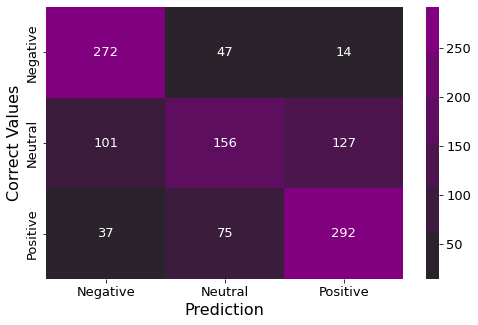

In [68]:
confusion_metrix_plot(x_val, y_val, rnn_model)

We can see that the validation accuracy is low, and loss is getting increasing that why the early stopping trigered.
- The model is not good and if it is trained for longer it will overfit.
- So we are going to use some regularization techniques and also going to increase the size of model.
- For validation and training accuracy we are using tensorboard

But before that lets try to save the model and load the model for deployment purpose
I tried to save the model but when going to load it shows error, i solved that error by deleting mask_zero part from embedding layer

In [69]:
rnn_model.save('Model_files/rnn_model.tf')

INFO:tensorflow:Assets written to: Model_files/rnn_model.tf\assets


### RNN model 2

In [74]:
EMBEDDING = 30
SENTENCE_LENGTH = 150
VOCAB_SIZE = 7500
RNN_NODES = 75


Model_name = 'rnn_model_2_'
# LOG_DIR = 'logs/' + +datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

def log_dir():
    LOG_DIR = 'logs/fit/'+Model_name + datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S')
    return LOG_DIR

In [75]:
encoder = TextVectorization(max_tokens = VOCAB_SIZE, output_sequence_length = SENTENCE_LENGTH) 
encoder.adapt(x_train)


rnn_model_2 = Sequential([
    encoder,
    Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING),
    SimpleRNN(RNN_NODES),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

rnn_model_2.compile(optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir(), write_graph= True)

In [76]:
rnn_model_2.fit(x_train, y_train, epochs = 10, callbacks= [tensorboard_callback],validation_data= (x_val, y_val))

Epoch 1/10
105/105 [==============================] - 74s 682ms/step - loss: 1.1104 - accuracy: 0.3551 - val_loss: 1.1182 - val_accuracy: 0.3274
Epoch 2/10
105/105 [==============================] - 67s 638ms/step - loss: 1.1363 - accuracy: 0.3408 - val_loss: 1.1083 - val_accuracy: 0.3408
Epoch 3/10
105/105 [==============================] - 73s 697ms/step - loss: 1.1133 - accuracy: 0.3452 - val_loss: 1.0963 - val_accuracy: 0.3408
Epoch 4/10
105/105 [==============================] - 67s 635ms/step - loss: 1.0941 - accuracy: 0.3744 - val_loss: 1.0963 - val_accuracy: 0.3399
Epoch 5/10
105/105 [==============================] - 70s 671ms/step - loss: 1.0960 - accuracy: 0.3589 - val_loss: 1.0935 - val_accuracy: 0.3497
Epoch 6/10
105/105 [==============================] - 61s 585ms/step - loss: 1.1041 - accuracy: 0.3545 - val_loss: 1.1000 - val_accuracy: 0.3541
Epoch 7/10
105/105 [==============================] - 66s 633ms/step - loss: 1.1014 - accuracy: 0.3560 - val_loss: 1.0993 - val_ac

In [77]:
rnn_model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_5 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 150, 30)           225000    
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 75)                7950      
                                                                 
 dropout_3 (Dropout)         (None, 75)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 228       
                                                                 
Total params: 233,178
Trainable params: 233,178
Non-trainable params: 0
________________________________________________

As we can see the model is worst, only giving accuracy of 36% and the accuracy is not increasing with epochs, so there may be the problem of vanishing gradient.


               precision    recall  f1-score   support

           0       0.00      0.00      0.00       326
           1       0.27      0.12      0.16       371
           2       0.37      0.84      0.52       424

    accuracy                           0.36      1121
   macro avg       0.21      0.32      0.23      1121
weighted avg       0.23      0.36      0.25      1121



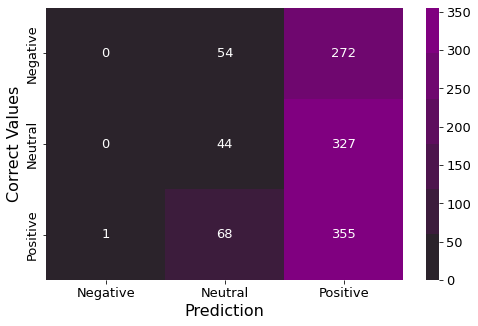

In [78]:
confusion_metrix_plot(x_val, y_val, rnn_model_2)

### RNN model 3

As the model 2 is overfitting we are going to reduce the no of RNN nodes and increase the epochs as well as dropout rate

In [57]:
EMBEDDING = 40
SENTENCE_LENGTH = 150
VOCAB_SIZE = 7500
RNN_NODES = 80


Model_name = 'rnn_model_3_'
# LOG_DIR = 'logs/' + +datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

def log_dir():
    LOG_DIR = 'logs/fit/'+Model_name + datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S')
    return LOG_DIR

In [58]:
encoder = TextVectorization(max_tokens= VOCAB_SIZE, output_sequence_length= SENTENCE_LENGTH)
encoder.adapt(x_train)

In [59]:
rnn_model_3 = Sequential([
    encoder,
    Embedding(input_dim = VOCAB_SIZE, output_dim=EMBEDDING),
    Dropout(0.2),
    SimpleRNN(RNN_NODES),
    Dense(3, activation = 'softmax')
])

rnn_model_3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.01),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics= ['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= log_dir())
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 2)

In [60]:
rnn_model_3.fit(x_train, y_train, epochs = 30, callbacks=[tensorboard_callback, early_callback], validation_data= (x_val, y_val))

Epoch 1/30
105/105 [==============================] - 69s 635ms/step - loss: 1.1776 - accuracy: 0.3429 - val_loss: 1.1034 - val_accuracy: 0.3345
Epoch 2/30
105/105 [==============================] - 75s 714ms/step - loss: 1.1220 - accuracy: 0.3616 - val_loss: 1.1769 - val_accuracy: 0.3568
Epoch 3/30
105/105 [==============================] - 73s 694ms/step - loss: 1.1263 - accuracy: 0.3601 - val_loss: 1.1462 - val_accuracy: 0.3693
Epoch 4/30
105/105 [==============================] - 73s 694ms/step - loss: 1.1211 - accuracy: 0.3545 - val_loss: 1.1173 - val_accuracy: 0.3559
Epoch 5/30
105/105 [==============================] - 70s 666ms/step - loss: 1.1212 - accuracy: 0.3652 - val_loss: 1.1377 - val_accuracy: 0.3586


1. I tried the model with kernal intialization, kernel regularization, recurrent-dropout and with 50 RNN nodes but the model in not making any progress.
2. then I removed those things and tried without changing activation of RNN but still same result.
3. with change in Activation same result
4. Now lets increase RNN nodes and embeddings, but still no progress. Now lets try our first model as 4th one

### RNN_4 or RNN 1

In [61]:
EMBEDDING = 20
SENTENCE_LENGTH = 150
VOCAB_SIZE = 7500
Model_name = 'rnn_model_4(1)_'
# LOG_DIR = 'logs/' + +datetime.datetime.now().strftime("%Y%m%d-%H_%M_%S")

def log_dir():
    LOG_DIR = 'logs/fit/'+Model_name + datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S')
    return LOG_DIR

In [62]:
encoder = TextVectorization(max_tokens= VOCAB_SIZE, output_sequence_length= 150)
encoder.adapt(x_train)

In [63]:
rnn_model_4 = Sequential([
    encoder,
    Embedding(input_dim= VOCAB_SIZE, output_dim=EMBEDDING, mask_zero= True),
    layers.Dropout(0.2),
    SimpleRNN(50),
    layers.Dense(3, activation= 'softmax')
])

# log_dir_1 = log_dir()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= log_dir())
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy' , patience= 2)

rnn_model_4.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.01),
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics= ['accuracy'])

In [64]:
rnn_model_4.fit(x_train, y_train, epochs= 20, 
    validation_data = (x_val, y_val),callbacks= [tensorboard_callback, early_callback],
     )

Epoch 1/20
105/105 [==============================] - 117s 1s/step - loss: 1.0039 - accuracy: 0.4869 - val_loss: 0.7953 - val_accuracy: 0.6307
Epoch 2/20
105/105 [==============================] - 100s 949ms/step - loss: 0.7464 - accuracy: 0.6560 - val_loss: 0.9468 - val_accuracy: 0.5227
Epoch 3/20
105/105 [==============================] - 104s 990ms/step - loss: 0.6667 - accuracy: 0.7214 - val_loss: 0.9565 - val_accuracy: 0.5995


### RNN 5

In [103]:
EMBEDDING = 50
SENTENCE_LENGTH = 150
VOCAB_SIZE = 3400
RNN_NODES = 20


Model_name = 'rnn_model_5_'
# LOG_DIR = 'logs/' + +datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

def log_dir():
    LOG_DIR = 'logs/fit/'+Model_name + datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S')
    return LOG_DIR

In [104]:
encoder = TextVectorization(max_tokens= VOCAB_SIZE, output_sequence_length= SENTENCE_LENGTH)
encoder.adapt(x_train)

In [106]:
rnn_model_5 = Sequential([
    encoder,
    Embedding(input_dim = VOCAB_SIZE, output_dim=EMBEDDING),
    Dropout(0.2),
    SimpleRNN(RNN_NODES, kernel_regularizer= 'l2', recurrent_regularizer= 'l2', recurrent_dropout= 0.2),
    Dense(3, activation = 'softmax')
])

rnn_model_5.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.01),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics= ['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= log_dir(), histogram_freq=1  )
# early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 2)

In [108]:
rnn_model_5.fit(x_train, y_train, epochs = 20, callbacks=[tensorboard_callback], validation_data= (x_val, y_val))

KeyboardInterrupt: 

we tried this model but no changes in working,

Let's create another one with padding given externally

### RNN 6

In [90]:
encoder = TextVectorization(max_tokens= 7500, output_sequence_length= 150)
encoder.adapt(x_train)

In [94]:
encoder(x_train)

<tf.Tensor: shape=(3360, 150), dtype=int64, numpy=
array([[ 698,  205,   14, ...,    0,    0,    0],
       [  92,   28,   14, ...,    0,    0,    0],
       [  18,  163,   84, ...,    0,    0,    0],
       ...,
       [   4,    9,    3, ...,    0,    0,    0],
       [   2,    3,    2, ...,    0,    0,    0],
       [1015,    3, 5174, ...,    0,    0,    0]], dtype=int64)>

## LSTM

### LSTM 1

In [70]:
EMBEDDING =50
VOCAB_SIZE = 7500
SENTENCE_LENGTH = 150
Model_name = 'lstm_model_'

def log_dir():
    LOG_DIR = 'logs/fit/'+Model_name + datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S')
    return LOG_DIR

In [71]:
encode = TextVectorization(max_tokens = VOCAB_SIZE, output_sequence_length= 150)
encode.adapt(x_train)

In [72]:
lstm_model = Sequential([
    encode,
    Embedding(input_dim = VOCAB_SIZE, output_dim= EMBEDDING),
    LSTM(64),
    layers.Dense(3, activation = 'softmax')
])

lstm_model.compile(optimizer= tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy'] )

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir())


In [73]:
lstm_model.fit(x_train, y_train, epochs = 40, callbacks = [tensorboard_callback])

Epoch 1/40
105/105 [==============================] - 53s 30ms/step - loss: 1.0982 - accuracy: 0.3491
Epoch 2/40
105/105 [==============================] - 3s 29ms/step - loss: 1.0965 - accuracy: 0.3515
Epoch 3/40
105/105 [==============================] - 4s 36ms/step - loss: 1.0950 - accuracy: 0.3583
Epoch 4/40
105/105 [==============================] - 3s 30ms/step - loss: 1.1087 - accuracy: 0.3548
Epoch 5/40
105/105 [==============================] - 3s 32ms/step - loss: 1.1001 - accuracy: 0.3622
Epoch 6/40
105/105 [==============================] - 4s 33ms/step - loss: 1.0971 - accuracy: 0.3589
Epoch 7/40
105/105 [==============================] - 4s 36ms/step - loss: 1.0955 - accuracy: 0.3568
Epoch 8/40
105/105 [==============================] - 3s 31ms/step - loss: 1.0939 - accuracy: 0.3515 0s - loss: 1.0935 - 
Epoch 9/40
105/105 [==============================] - 3s 30ms/step - loss: 1.0943 - accuracy: 0.3479
Epoch 10/40
105/105 [==============================] - 3s 28ms/step -

In [74]:
lstm_model.evaluate(x_val, y_val)

36/36 [==============================] - 29s 27ms/step - loss: 0.6896 - accuracy: 0.8662


[0.6896207928657532, 0.8661909103393555]

In [76]:
np.argmax(lstm_model.predict(['phone is worst']))

0

In [77]:
lstm_model.save('Model_files/lstm_model.tf')

INFO:tensorflow:Assets written to: Model_files/lstm_model.tf\assets


INFO:tensorflow:Assets written to: Model_files/lstm_model.tf\assets


In [80]:
model = tf.keras.models.load_model('Model_files/lstm_model.tf')

SyntaxError: invalid syntax (Temp/ipykernel_10736/42849339.py, line 1)

In [81]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, None, 50)          375000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 404,635
Trainable params: 404,635
Non-trainable params: 0
_________________________________________________________________


In [82]:
model.predict(['good phone'])

array([[0.12131561, 0.08457218, 0.7941122 ]], dtype=float32)


               precision    recall  f1-score   support

           0       0.87      0.87      0.87       333
           1       0.79      0.83      0.81       384
           2       0.94      0.90      0.92       404

    accuracy                           0.87      1121
   macro avg       0.87      0.87      0.87      1121
weighted avg       0.87      0.87      0.87      1121



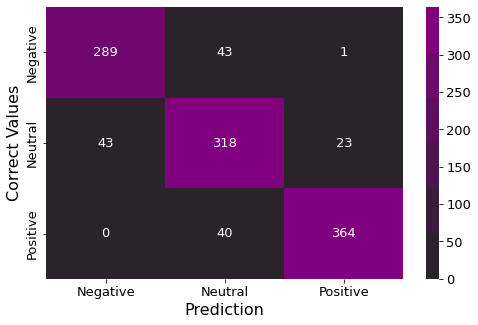

In [83]:
confusion_metrix_plot(x_val, y_val, lstm_model)

So even LSTM not giving any progress upto 14 epochs, so lets try another RNN with same epochs as lstm without any early stopping

### LSTM 2

In [109]:
EMBEDDING = 70
VOCAB_SIZE = 7500
SENTENCE_LENGTH = 150
Model_name = 'lstm_model_2_'

def log_dir():
    LOG_DIR = 'logs/fit/'+Model_name + datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S')
    return LOG_DIR

In [110]:
encode = TextVectorization(max_tokens = VOCAB_SIZE, output_sequence_length= 150)
encode.adapt(x_train)

In [115]:
lstm_model_2 = Sequential([
    encode,
    Embedding(input_dim = VOCAB_SIZE, output_dim= EMBEDDING),
    Dropout(0.2),
    LSTM(64, activation= 'relu' ,kernel_regularizer = 'l2', dropout = 0.2),
    layers.Dense(3, activation = 'softmax')
])

lstm_model_2.compile(optimizer= tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy'] )

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir())


In [116]:
lstm_model_2.fit(x_train, y_train, epochs = 30, callbacks = [tensorboard_callback])

Epoch 1/30
105/105 [==============================] - 145s 1s/step - loss: 1.4954 - accuracy: 0.3545
Epoch 2/30
 15/105 [===>..........................] - ETA: 2:00 - loss: 1.1585 - accuracy: 0.3333

KeyboardInterrupt: 